# Arousal-Driven Serial Dependence: Data Analysis

This notebook contains the complete data analysis pipeline for reproducing the manuscript figures and statistical tests.

**Last updated**: December 2025

## Contents
1. Setup and Data Loading
2. Figure 1: Central Tendency Effects
   - A. Paradigm schematic (external file)
   - B. Time error by arousal and valence
   - C. Central tendency index
   - D. General bias (central tendency)
3. Figure 2: Serial Dependence Effects
   - A. Serial dependence curves
   - B. Serial dependence index
   - C. General bias (serial dependence)
   - D. n-back analysis (high arousal)
   - E. n-back analysis (low arousal)

## 1. Setup and Data Loading

In [ ]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.formula.api as smf
from patsy.contrasts import Sum
import pingouin as pg
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure paths
WorkingPath = os.getcwd()
DataPath = os.path.join(WorkingPath, 'Results')
FigurePath = os.path.join(WorkingPath, 'Figures')
os.makedirs(FigurePath, exist_ok=True)

print(f"Working directory: {WorkingPath}")
print(f"Data path: {DataPath}")
print(f"Figure path: {FigurePath}")

In [406]:
# Define color palette: Blue and Orange optimized for B&W printing
# These colors have strong grayscale contrast (>80 points difference)

# 4-level palette: 2 blues + 2 oranges
# Grayscale values when printed: 87, 157, 118, 176
colors_4level = [
    '#0072B2',  # Dark blue (gray: 87)
    '#56B4E9',  # Sky blue (gray: 157)
    '#D55E00',  # Dark orange (gray: 118)
    '#F0A830'   # Light orange (gray: 176)
]

# 2-level palette: Dark blue + Light orange (MAXIMUM contrast)
# Grayscale values: 87 vs 176 (difference: 89)
colors_2level = [
    '#0072B2',  # Dark blue (gray: 87)
    '#F0A830'   # Light orange (gray: 176)
]

# Hatching patterns for bar plots
hatches_2level = ['', '///']  # None vs diagonal (second bar gets hatching)
hatches_4level = ['', '///', '\\\\\\', '|||']

# Line styles for line plots
linestyles_4level = ['-', '--', '-.', ':']

# Markers for data points
markers_4level = ['o', 's', '^', 'D']

# Set global plotting style with LARGER fonts for composite figures
sns.set_theme(style='white', font='Arial', font_scale=2.0)  # Increased from 1.5
sns.set_context('paper', rc={
    'lines.linewidth': 2.5,      # Thicker lines
    'lines.markersize': 8,       # Larger markers
    'axes.linewidth': 1.5,       # Thicker axes
    'xtick.major.width': 1.5,
    'ytick.major.width': 1.5,
    'font.size': 16,             # Base font size
    'axes.labelsize': 18,        # Axis labels
    'axes.titlesize': 20,        # Titles
    'xtick.labelsize': 16,       # Tick labels
    'ytick.labelsize': 16,
    'legend.fontsize': 16,       # Legend
})


In [432]:
# Load and preprocess data
raw = pd.read_csv(os.path.join(DataPath, 'AllSubCleanBackData1.csv'))

# Remove unnamed index column if present
if 'Unnamed: 0' in raw.columns:
    raw = raw.drop(columns=['Unnamed: 0'])

# Reset index
raw = raw.reset_index(drop=True)

# Filter outliers and invalid trials
raw = raw.query('TimeOutlier != 1 & RT_Outlier != 1 & TimeUnRes != 1')
raw = raw.query('PressTimeError != 9999')

print(f"Total valid trials: {len(raw)}")
print(f"Participants: {sorted(raw.SubID.unique())}")
print(f"Number of participants: {len(raw.SubID.unique())}")



Total valid trials: 13196
Participants: [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0]
Number of participants: 21


Note: 
- Trial Type: Stimulus Arousal
- Block Type: Positive / Negative Valence



In [408]:
# Helper function to add significance stars to plots
def add_significance_stars(ax, x1, x2, y, p_value, height_offset=0.02):
    """
    Add significance markers to plots.
    
    Parameters:
    -----------
    ax : matplotlib axis
    x1, x2 : float
        x-coordinates for the two groups being compared
    y : float
        y-coordinate for the line
    p_value : float
        p-value from statistical test
    height_offset : float
        vertical spacing for the bracket
    """
    # Determine significance level
    if p_value < 0.001:
        stars = '***'
    elif p_value < 0.01:
        stars = '**'
    elif p_value < 0.05:
        stars = '*'
    else:
        stars = 'n.s.'
    
    # Draw bracket
    ax.plot([x1, x1, x2, x2], [y, y+height_offset, y+height_offset, y], 
            linewidth=1.5, c='black')
    
    # Add text
    ax.text((x1+x2)*0.5, y+height_offset, stars, 
            ha='center', va='bottom', fontsize=14, weight='bold')
    
    return stars

## 2. Figure 1: Central Tendency Effects

This section analyzes how emotional arousal and valence affect central tendency bias in temporal reproduction.

### Figure 1B: Time Error by Arousal and Valence

Plots reproduction error as a function of current duration, separated by emotional arousal and valence.

In [409]:
# Statistical analysis: Mixed-effects model for central tendency
# Center duration around midpoint (1.2s)
raw['TimeDur_centered'] = raw['TimeDur'] - 1.2

# Aggregate by subject for mixed model
mPM = raw.groupby(['SubID', 'BlockType', 'TrialType', 'TimeDur']).agg(
    {'PressTimeError': 'mean'}
).reset_index()
mPM.columns = ['SubID', 'BlockType', 'TrialType', 'TimeDur', 'sPM']
mPM['TimeDur_centered'] = mPM['TimeDur'] - 1.2

# Fit mixed-effects model with sum contrasts
model_ct = smf.mixedlm(
    "sPM ~ TimeDur_centered * C(BlockType, Sum) * C(TrialType, Sum)",
    data=mPM,
    groups=mPM['SubID']
).fit(reml=False)

print("\n=== Mixed-Effects Model: Central Tendency ===")
print(model_ct.summary())


=== Mixed-Effects Model: Central Tendency ===
                                       Mixed Linear Model Regression Results
Model:                                  MixedLM                     Dependent Variable:                     sPM     
No. Observations:                       420                         Method:                                 ML      
No. Groups:                             21                          Scale:                                  0.0039  
Min. group size:                        20                          Log-Likelihood:                         536.0918
Max. group size:                        20                          Converged:                              Yes     
Mean group size:                        20.0                                                                        
--------------------------------------------------------------------------------------------------------------------
                                                         

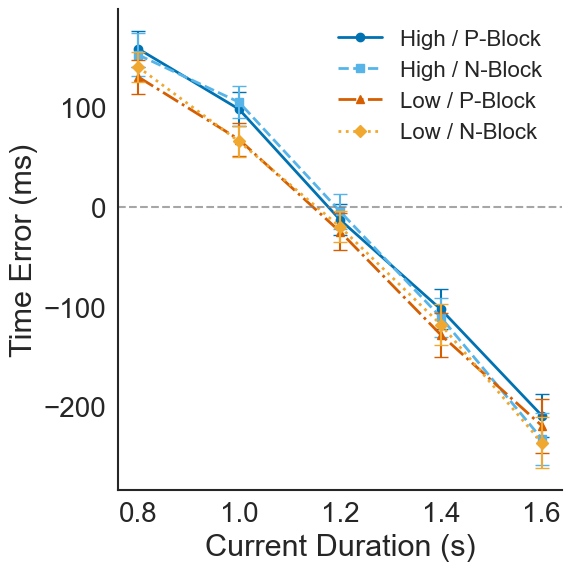


Figure 1B saved: Valence_CT_Error_bar.png


In [410]:
# Prepare data for plotting Figure 1B
PlotData_CT = raw.groupby(['SubID', 'BlockType', 'TrialType', 'TimeDur']).agg(
    {'PressTimeError': 'mean'}
).reset_index()

# Convert to milliseconds
PlotData_CT['PressTimeError_ms'] = PlotData_CT['PressTimeError'] * 1000

# Create Figure 1B - Single panel with 4 lines
plt.figure(figsize=(6, 6))

# Define all four conditions
conditions = [
    ('High', 'Positive'),
    ('High', 'Negative'),
    ('Low', 'Positive'),
    ('Low', 'Negative')
]

# Plot all four lines in one figure
for i, (trial_type, block_type) in enumerate(conditions):
    data_subset = PlotData_CT[
        (PlotData_CT['TrialType'] == trial_type) & 
        (PlotData_CT['BlockType'] == block_type)
    ]
    
    # Calculate mean and SEM in milliseconds
    summary = data_subset.groupby('TimeDur').agg(
        mean=('PressTimeError_ms', 'mean'),
        sem=('PressTimeError_ms', 'sem')
    ).reset_index()
    
    # Plot with blue/orange colors and distinct styles
    plt.plot(summary['TimeDur'], summary['mean'],
            color=colors_4level[i],
            linestyle=linestyles_4level[i],
            marker=markers_4level[i],
            linewidth=2, markersize=6,
            label=f"{trial_type} / {block_type[0]}-Block")
    
    # Add error bars
    plt.errorbar(summary['TimeDur'], summary['mean'],
                yerr=summary['sem'],
                color=colors_4level[i],
                fmt='none', capsize=5, linewidth=1.5)

# Add reference line at y=0
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

# Formatting
plt.xlabel('Current Duration (s)', fontsize=22)
plt.ylabel('Time Error (ms)', fontsize=22)  # Changed to ms
plt.tick_params(labelsize=20, top=False, bottom=False, left=False, right=False)
plt.legend(loc='best', fontsize=16, frameon=False)
sns.despine(top=True, right=True, left=False, bottom=False)

plt.tight_layout()
plt.savefig(os.path.join(FigurePath, 'Valence_CT_Error_bar.png'), dpi=600, bbox_inches='tight')
plt.show()

print("\nFigure 1B saved: Valence_CT_Error_bar.png")


### Figure 1C & 1D: Central Tendency Index and General Bias

For each participant and condition, we regress reproduction error on duration to extract:
- **Slope**: Central tendency index (rate of regression to the mean)
- **Intercept**: General bias (overall over- or underestimation)

In [434]:
# Regression analysis: Extract CT index and general bias for each participant
# IMPORTANT: Center TimeDur around midpoint (1.2s) for correct intercept interpretation
from scipy.stats import linregress

# Create centered TimeDur variable
rawCT = raw.copy()
rawCT['TimeDur'] = rawCT['TimeDur'] - 1.2  # Center around midpoint

reg_results = []

# Loop through each combination of subject, arousal, and valence
for (sub, block, trial), group in rawCT.groupby(['SubID', 'BlockType', 'TrialType']):
    # Perform linear regression: PressTimeError ~ TimeDur (centered)
    slope, intercept, r_value, p_value, std_err = linregress(
        group['TimeDur'], group['PressTimeError']
    )
    
    # Calculate indifference point (where error = 0)
    # Add back 1.2 to convert to original scale
    indiff_point = (-intercept / slope) + 1.2 if slope != 0 else np.nan
    
    reg_results.append({
        'SubID': sub,
        'BlockType': block,
        'TrialType': trial,
        'Slope': slope,
        'Intercept': intercept,  # Now represents bias at midpoint (1.2s)
        'IPs': indiff_point,
        'r_value': r_value,
        'p_value': p_value
    })

reg_BlockType = pd.DataFrame(reg_results)

print("\nRegression summary (first 10 rows):")
print(reg_BlockType.head(10))
print(f"\nTotal regression models fitted: {len(reg_BlockType)}")
print("\nNote: TimeDur was centered at 1.2s, so Intercept = general bias at midpoint")

# save regression results
reg_BlockType.to_csv(os.path.join(DataPath, 'CT_Regression_Results.csv'), index=False)


Regression summary (first 10 rows):
   SubID BlockType TrialType     Slope  Intercept       IPs   r_value  \
0    1.0  Negative      High -0.686381  -0.066369  1.103306 -0.737272   
1    1.0  Negative       Low -0.638484  -0.073352  1.085115 -0.679777   
2    1.0  Positive      High -0.588408  -0.014688  1.175037 -0.608412   
3    1.0  Positive       Low -0.488164  -0.053842  1.089706 -0.638874   
4    2.0  Negative      High -0.473470   0.004804  1.210146 -0.669027   
5    2.0  Negative       Low -0.369846  -0.014301  1.161331 -0.588980   
6    2.0  Positive      High -0.554637  -0.020286  1.163425 -0.741960   
7    2.0  Positive       Low -0.415875  -0.027310  1.134331 -0.632353   
8    3.0  Negative      High -0.811448  -0.121393  1.050400 -0.812060   
9    3.0  Negative       Low -0.586368  -0.136997  0.966363 -0.699105   

        p_value  
0  3.449059e-28  
1  1.259153e-22  
2  1.794216e-17  
3  4.879883e-19  
4  5.515801e-22  
5  7.581538e-16  
6  4.673857e-29  
7  5.044383e-19

In [412]:
# Statistical test: RM-ANOVA for Central Tendency Index (Slope)
anova_ct = pg.rm_anova(
    data=reg_BlockType,
    dv='Slope',
    within=['BlockType', 'TrialType'],
    subject='SubID',
    effsize='np2'
)

print("\n=== RM-ANOVA: Central Tendency Index (Slope) ===")
pg.print_table(anova_ct, floatfmt='.3f')

# Post-hoc pairwise comparisons
# Add numeric coding for pairwise tests
reg_BlockType['BlockType_Num'] = reg_BlockType['BlockType'].map({'Positive': 0, 'Negative': 1})
reg_BlockType['TrialType_Num'] = reg_BlockType['TrialType'].map({'High': 0, 'Low': 1})

posthoc_ct = pg.pairwise_tests(
    data=reg_BlockType,
    dv='Slope',
    within=['BlockType_Num', 'TrialType_Num'],
    subject='SubID',
    padjust='bonf'
)

print("\n=== Post-hoc Tests: Central Tendency Index ===")
pg.print_table(posthoc_ct, floatfmt='.3f')


=== RM-ANOVA: Central Tendency Index (Slope) ===

ANOVA SUMMARY

Source                    SS    ddof1    ddof2     MS      F    p-unc    p-GG-corr    np2    eps
---------------------  -----  -------  -------  -----  -----  -------  -----------  -----  -----
BlockType              0.011        1       20  0.011  2.274    0.147        0.147  0.102  1.000
TrialType              0.011        1       20  0.011  1.607    0.219        0.219  0.074  1.000
BlockType * TrialType  0.000        1       20  0.000  0.037    0.849        0.849  0.002  1.000


=== Post-hoc Tests: Central Tendency Index ===

POST HOC TESTS

Contrast                       BlockType_Num      A    B  Paired    Parametric         T     dof  alternative      p-unc    p-corr  p-adjust      BF10    hedges
-----------------------------  ---------------  ---  ---  --------  ------------  ------  ------  -------------  -------  --------  ----------  ------  --------
BlockType_Num                  -                  0    1  Tru

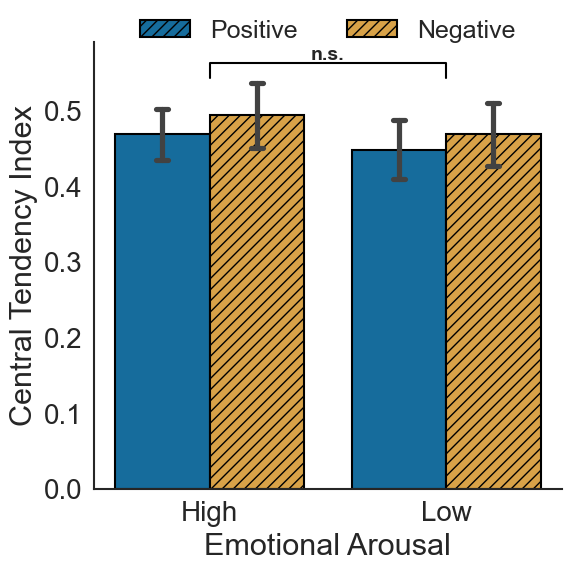


Figure 1C saved: Res_CT_bar.png


In [413]:
# Create Figure 1C: Central Tendency Index
PlotData_CTC = reg_BlockType.copy()
PlotData_CTC['Slope_abs'] = np.abs(PlotData_CTC['Slope'])  # Take absolute value

plt.figure(figsize=(6, 6))

# Prepare data for barplot
plot_order = ['High', 'Low']
hue_order = ['Positive', 'Negative']

# Create barplot
ax = sns.barplot(
    data=PlotData_CTC,
    x='TrialType',
    y='Slope_abs',
    hue='BlockType',
    order=plot_order,
    hue_order=hue_order,
    palette=colors_2level,
    errorbar=('se', 1),
    capsize=0.1,
    edgecolor='black',
    linewidth=1.5
)

# Add hatching patterns 
for i, bar in enumerate(ax.patches):
    if i  > 1:  
        bar.set_hatch('///')

# Get y-axis range for positioning
y_max = PlotData_CTC.groupby(['TrialType', 'BlockType'])['Slope_abs'].mean().max()
y_range = ax.get_ylim()[1] - ax.get_ylim()[0]

# Position legend ABOVE where significance will be (at top of plot)
ax.legend(title='', fontsize=18, frameon=False, loc='upper center', 
          bbox_to_anchor=(0.5, 1.1), ncol=2)

# Add significance marker below legend: n.s. between High vs Low (positions 0 and 1)
add_significance_stars(ax, 0, 1, y_max * 1.1, p_value=0.10)

# Formatting
ax.set_xlabel('Emotional Arousal', fontsize=22)
ax.set_ylabel('Central Tendency Index', fontsize=22)
ax.tick_params(labelsize=20, top=False, bottom=False, left=False, right=False)
sns.despine(top=True, right=True, left=False, bottom=False)

plt.tight_layout()
plt.savefig(os.path.join(FigurePath, 'Res_CT_bar.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure 1C saved: Res_CT_bar.png")


In [414]:
# Statistical test: RM-ANOVA for General Bias (Intercept)
anova_gb = pg.rm_anova(
    data=reg_BlockType,
    dv='Intercept',
    within=['BlockType', 'TrialType'],
    subject='SubID',
    effsize='np2'
)

print("\n=== RM-ANOVA: General Bias (Intercept) ===")
pg.print_table(anova_gb, floatfmt='.3f')

# Post-hoc pairwise comparisons
posthoc_gb = pg.pairwise_tests(
    data=reg_BlockType,
    dv='Intercept',
    within=['BlockType_Num', 'TrialType_Num'],
    subject='SubID',
    padjust='bonf'
)

print("\n=== Post-hoc Tests: General Bias ===")
pg.print_table(posthoc_gb, floatfmt='.3f')


=== RM-ANOVA: General Bias (Intercept) ===

ANOVA SUMMARY

Source                    SS    ddof1    ddof2     MS       F    p-unc    p-GG-corr    np2    eps
---------------------  -----  -------  -------  -----  ------  -------  -----------  -----  -----
BlockType              0.000        1       20  0.000   0.063    0.804        0.804  0.003  1.000
TrialType              0.007        1       20  0.007  13.555    0.001        0.001  0.404  1.000
BlockType * TrialType  0.000        1       20  0.000   0.501    0.487        0.487  0.024  1.000


=== Post-hoc Tests: General Bias ===

POST HOC TESTS

Contrast                       BlockType_Num      A    B  Paired    Parametric        T     dof  alternative      p-unc    p-corr  p-adjust      BF10    hedges
-----------------------------  ---------------  ---  ---  --------  ------------  -----  ------  -------------  -------  --------  ----------  ------  --------
BlockType_Num                  -                  0    1  True      True  

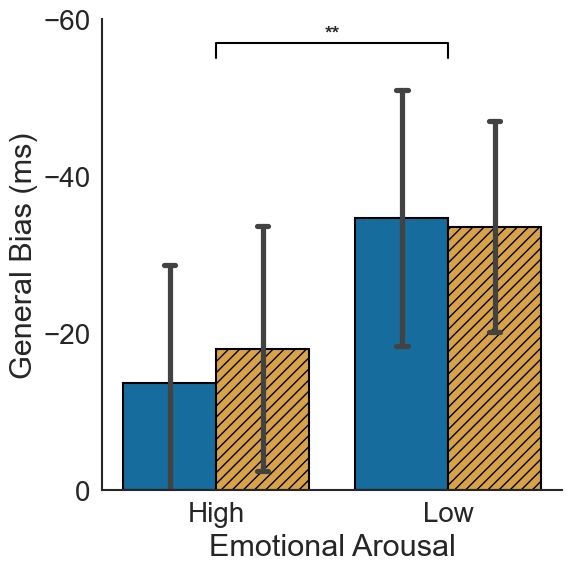


Figure 1D saved: GB_CT_bar.png


In [415]:
# Create Figure 1D: General Bias
PlotData_GB = reg_BlockType.copy()
PlotData_GB['Intercept_ms'] = PlotData_GB['Intercept'] * 1000  # Convert to milliseconds

plt.figure(figsize=(6, 6))

# Create barplot (same as Figure 1C for consistency)
ax = sns.barplot(
    data=PlotData_GB,
    x='TrialType',
    y='Intercept_ms',
    hue='BlockType',
    order=['High', 'Low'],
    hue_order=['Positive', 'Negative'],
    palette=colors_2level,
    errorbar=('se', 1),
    capsize=0.1,
    edgecolor='black',
    linewidth=1.5
)

# Add hatching patterns - only on second bars (Negative)
for i, bar in enumerate(ax.patches):
    if i > 1:  
        bar.set_hatch('///')

# IMPORTANT: Set y-axis limits and ticks BEFORE inverting
# This ensures -60 appears at TOP and 0 at BOTTOM
ax.set_ylim(-60, 0)
ax.set_yticks([-60, -40, -20, 0])

# Add reference line at y=0
ax.axhline(y=0, color='black', linestyle='-', linewidth=2)

# Invert y-axis so negative values go UP (more negative = higher position)
ax.invert_yaxis()

# Add significance marker: ** between High and Low
# Position at y=-55 (which will appear near top after inversion)
add_significance_stars(ax, 0, 1, -55, p_value=0.005, height_offset=-2)

# Formatting
ax.set_xlabel('Emotional Arousal', fontsize=22)
ax.set_ylabel('General Bias (ms)', fontsize=22)
ax.tick_params(labelsize=20, top=False, bottom=False, left=False, right=False)
ax.legend([], [], frameon=False)  # Remove legend
sns.despine(top=True, right=True, left=False, bottom=False)

plt.tight_layout()
plt.savefig(os.path.join(FigurePath, 'GB_CT_bar.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure 1D saved: GB_CT_bar.png")

## 3. Figure 2: Serial Dependence Effects

This section analyzes how emotional arousal affects serial dependence in temporal reproduction.

In [416]:
# Prepare data for serial dependence analysis
# Remove trials without prior information
rawOneBack = raw[raw['Condition'] != '0.0'].copy()

# Extract prior arousal level from Condition code
# Condition format: 'XY' where X = prior arousal, Y = current arousal
# H = High, L = Low
rawOneBack['Condition_Prior'] = rawOneBack['Condition'].str[0]
rawOneBack['Condition_Current'] = rawOneBack['Condition'].str[1]

print(f"\nTrials with prior information: {len(rawOneBack)}")
print(f"Conditions: {sorted(rawOneBack['Condition'].unique())}")
print("\nCondition breakdown:")
print(rawOneBack.groupby(['Condition_Prior', 'Condition_Current']).size())


Trials with prior information: 12871
Conditions: ['HH', 'HL', 'LH', 'LL']

Condition breakdown:
Condition_Prior  Condition_Current
H                H                    3193
                 L                    3249
L                H                    3248
                 L                    3181
dtype: int64


### Figure 2A: Serial Dependence Curves

Plots reproduction error as a function of previous trial duration, showing how the prior duration biases current reproduction.

In [417]:
# Statistical analysis: Mixed-effects model for serial dependence
# Center previous duration around midpoint
rawOneBack['nBack_Time_centered'] = rawOneBack['nBack_Time'] - 1.2

# Aggregate by subject for mixed model
mPM_SD = rawOneBack.groupby(
    ['SubID', 'BlockType', 'TrialType', 'Condition_Prior', 'nBack_Time']
).agg({'PressTimeError': 'mean'}).reset_index()
mPM_SD.columns = ['SubID', 'BlockType', 'TrialType', 'Condition_Prior', 'nBack_Time', 'sPM']
mPM_SD['nBack_Time_centered'] = mPM_SD['nBack_Time'] - 1.2

# Fit mixed-effects model with sum contrasts
model_sd = smf.mixedlm(
    "sPM ~ nBack_Time_centered * C(BlockType, Sum) * C(TrialType, Sum) * C(Condition_Prior, Sum)",
    data=mPM_SD,
    groups=mPM_SD['SubID']
).fit(reml=False)

print("\n=== Mixed-Effects Model: Serial Dependence ===")
print(model_sd.summary())


=== Mixed-Effects Model: Serial Dependence ===
                                                       Mixed Linear Model Regression Results
Model:                                            MixedLM                               Dependent Variable:                               sPM      
No. Observations:                                 840                                   Method:                                           ML       
No. Groups:                                       21                                    Scale:                                            0.0042   
Min. group size:                                  40                                    Log-Likelihood:                                   1066.8995
Max. group size:                                  40                                    Converged:                                        Yes      
Mean group size:                                  40.0                                                                 

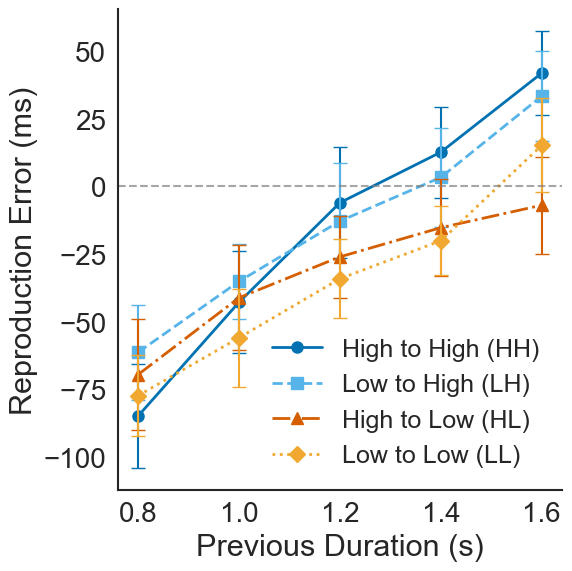


Figure 2A saved: SD_point.png


In [418]:
# Prepare data for plotting Figure 2A
PlotData_SD = rawOneBack.groupby(
    ['SubID', 'Condition', 'nBack_Time']
).agg({'PressTimeError': 'mean'}).reset_index()

# Convert to milliseconds
PlotData_SD['PressTimeError_ms'] = PlotData_SD['PressTimeError'] * 1000

# Create Figure 2A: Serial Dependence Curves
fig, ax = plt.subplots(figsize=(6, 6))

# Define condition order and labels
conditions = ['HH', 'LH', 'HL', 'LL']  # High to High, Low to High, etc.
condition_labels = [
    'High to High (HH)',
    'Low to High (LH)',
    'High to Low (HL)',
    'Low to Low (LL)'
]

# Plot each condition
for i, (cond, label) in enumerate(zip(conditions, condition_labels)):
    data_cond = PlotData_SD[PlotData_SD['Condition'] == cond]
    
    # Calculate mean and SEM in milliseconds
    summary = data_cond.groupby('nBack_Time').agg(
        mean=('PressTimeError_ms', 'mean'),
        sem=('PressTimeError_ms', 'sem')
    ).reset_index()
    
    # Plot with distinct blue/orange colors and styles
    ax.plot(summary['nBack_Time'], summary['mean'],
            color=colors_4level[i],
            linestyle=linestyles_4level[i],
            marker=markers_4level[i],
            linewidth=2, markersize=8,
            label=label)
    
    # Add error bars
    ax.errorbar(summary['nBack_Time'], summary['mean'],
                yerr=summary['sem'],
                color=colors_4level[i],
                fmt='none', capsize=5, linewidth=1.5)

# Add reference line at y=0
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1.5, alpha=0.7)

# Formatting
ax.set_xlabel('Previous Duration (s)', fontsize=22)
ax.set_ylabel('Reproduction Error (ms)', fontsize=22)  # Changed to ms
ax.tick_params(labelsize=20)
ax.legend(loc='best', fontsize=18, frameon=False)
sns.despine()

plt.tight_layout()
plt.savefig(os.path.join(FigurePath, 'SD_point.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure 2A saved: SD_point.png")


In [419]:
# Regression analysis: Extract SD index for each participant and condition
# IMPORTANT: Center nBack_Time around midpoint (1.2s) for correct intercept
from scipy.stats import linregress

# Create centered nBack_Time variable
rawSD = rawOneBack.copy()
rawSD['nBack_Time'] = rawSD['nBack_Time'] - 1.2  # Center around midpoint

reg_sd_results = []

for (sub, block, cond), group in rawSD.groupby(['SubID', 'BlockType', 'Condition']):
    # Perform linear regression: PressTimeError ~ nBack_Time (centered)
    slope, intercept, r_value, p_value, std_err = linregress(
        group['nBack_Time'], group['PressTimeError']
    )
    
    reg_sd_results.append({
        'SubID': sub,
        'BlockType': block,
        'Condition': cond,
        'Slope': slope,
        'Intercept': intercept,  # Now represents bias at midpoint (1.2s)
        'r_value': r_value,
        'p_value': p_value
    })

reg_seq = pd.DataFrame(reg_sd_results)

# Parse condition into prior and current arousal
reg_seq['Condition_Prior'] = reg_seq['Condition'].str[0]
reg_seq['Condition_Current'] = reg_seq['Condition'].str[1]

# Add numeric coding for statistical tests
reg_seq['BlockType_Num'] = reg_seq['BlockType'].map({'Positive': 0, 'Negative': 1})
reg_seq['Condition_Prior_Num'] = reg_seq['Condition_Prior'].map({'H': 0, 'L': 1})
reg_seq['Condition_Current_Num'] = reg_seq['Condition_Current'].map({'H': 0, 'L': 1})

print("\nSerial dependence regression summary (first 10 rows):")
print(reg_seq.head(10))
print(f"\nTotal SD regression models: {len(reg_seq)}")
print("\nNote: nBack_Time was centered at 1.2s, so Intercept = general bias at midpoint")



Serial dependence regression summary (first 10 rows):
   SubID BlockType Condition     Slope  Intercept   r_value   p_value  \
0    1.0  Negative        HH -0.097759  -0.056675 -0.104726  0.374543   
1    1.0  Negative        HL  0.327461  -0.038768  0.330132  0.003366   
2    1.0  Negative        LH  0.069621  -0.059100  0.073146  0.521764   
3    1.0  Negative        LL  0.163087  -0.110117  0.186131  0.107429   
4    1.0  Positive        HH  0.159071  -0.010508  0.155996  0.172617   
5    1.0  Positive        HL -0.020865  -0.033072 -0.029819  0.799526   
6    1.0  Positive        LH  0.156428  -0.006762  0.168159  0.141111   
7    1.0  Positive        LL  0.088047  -0.055245  0.109559  0.352776   
8    2.0  Negative        HH  0.169910   0.020856  0.237478  0.035087   
9    2.0  Negative        HL  0.018693   0.013023  0.025940  0.822806   

  Condition_Prior Condition_Current  BlockType_Num  Condition_Prior_Num  \
0               H                 H              1                

In [433]:
# Regression analysis: Extract SD index for each participant and condition
# CRITICAL: Center nBack_Time at 1.2s so intercept = general bias at midpoint
from scipy.stats import linregress

# Create centered version
rawOneBackSD = rawOneBack.copy()
rawOneBackSD['nBack_Time'] = rawOneBackSD['nBack_Time'] - 1.2  # Center at midpoint

reg_sd_results = []

for (sub, block, cond), group in rawOneBackSD.groupby(['SubID', 'BlockType', 'Condition']):
    # Perform linear regression: PressTimeError ~ nBack_Time (centered)
    slope, intercept, r_value, p_value, std_err = linregress(
        group['nBack_Time'], group['PressTimeError']
    )
    
    reg_sd_results.append({
        'SubID': sub,
        'BlockType': block,
        'Condition': cond,
        'Slope': slope,
        'Intercept': intercept,  # Now represents bias at 1.2s midpoint
        'r_value': r_value,
        'p_value': p_value
    })

reg_seq = pd.DataFrame(reg_sd_results)

# Parse condition into prior and current arousal
reg_seq['Condition_Prior'] = reg_seq['Condition'].str[0]
reg_seq['Condition_Current'] = reg_seq['Condition'].str[1]

# Add numeric coding for statistical tests
reg_seq['BlockType_Num'] = reg_seq['BlockType'].map({'Positive': 0, 'Negative': 1})
reg_seq['Condition_Prior_Num'] = reg_seq['Condition_Prior'].map({'H': 0, 'L': 1})
reg_seq['Condition_Current_Num'] = reg_seq['Condition_Current'].map({'H': 0, 'L': 1})

print("\nSerial dependence regression summary (first 10 rows):")
print(reg_seq.head(10))
print(f"\nTotal SD regression models: {len(reg_seq)}")
print("\nNote: nBack_Time centered at 1.2s → Intercept = general bias at midpoint")
# save regression results
reg_seq.to_csv(os.path.join(DataPath, 'SD_Regression_Results.csv'), index=False)


Serial dependence regression summary (first 10 rows):
   SubID BlockType Condition     Slope  Intercept   r_value   p_value  \
0    1.0  Negative        HH -0.097759  -0.056675 -0.104726  0.374543   
1    1.0  Negative        HL  0.327461  -0.038768  0.330132  0.003366   
2    1.0  Negative        LH  0.069621  -0.059100  0.073146  0.521764   
3    1.0  Negative        LL  0.163087  -0.110117  0.186131  0.107429   
4    1.0  Positive        HH  0.159071  -0.010508  0.155996  0.172617   
5    1.0  Positive        HL -0.020865  -0.033072 -0.029819  0.799526   
6    1.0  Positive        LH  0.156428  -0.006762  0.168159  0.141111   
7    1.0  Positive        LL  0.088047  -0.055245  0.109559  0.352776   
8    2.0  Negative        HH  0.169910   0.020856  0.237478  0.035087   
9    2.0  Negative        HL  0.018693   0.013023  0.025940  0.822806   

  Condition_Prior Condition_Current  BlockType_Num  Condition_Prior_Num  \
0               H                 H              1                

In [421]:
# Statistical tests: One-sample t-tests for each condition
print("\n=== One-Sample T-Tests: SD Index vs Zero ===")
print("\nTesting whether serial dependence differs from zero in each condition:\n")

for cond in ['HH', 'HL', 'LH', 'LL']:
    data_cond = reg_seq[reg_seq['Condition'] == cond]['Slope']
    ttest_result = pg.ttest(data_cond, 0)
    print(f"Condition {cond}:")
    pg.print_table(ttest_result, floatfmt='.3f')
    print()


=== One-Sample T-Tests: SD Index vs Zero ===

Testing whether serial dependence differs from zero in each condition:

Condition HH:
    T    dof  alternative      p-val  CI95%          cohen-d          BF10    power
-----  -----  -------------  -------  -----------  ---------  ------------  -------
7.907     41  two-sided        0.000  [0.11 0.19]      1.220  12650000.000    1.000


Condition HL:
    T    dof  alternative      p-val  CI95%          cohen-d     BF10    power
-----  -----  -------------  -------  -----------  ---------  -------  -------
4.119     41  two-sided        0.000  [0.04 0.11]      0.636  140.773    0.980


Condition LH:
    T    dof  alternative      p-val  CI95%          cohen-d         BF10    power
-----  -----  -------------  -------  -----------  ---------  -----------  -------
7.371     41  two-sided        0.000  [0.08 0.15]      1.137  2488000.000    1.000


Condition LL:
    T    dof  alternative      p-val  CI95%          cohen-d         BF10    powe

In [435]:
# Statistical test: RM-ANOVA for Serial Dependence Index
anova_sd = pg.rm_anova(
    data=reg_seq,
    dv='Slope',
    within=['Condition_Prior', 'Condition_Current'],
    subject='SubID',
    effsize='np2'
)

print("\n=== RM-ANOVA: Serial Dependence Index ===")
pg.print_table(anova_sd, floatfmt='.3f')

# Post-hoc pairwise comparisons with Bonferroni correction
posthoc_sd = pg.pairwise_tests(
    data=reg_seq,
    dv='Slope',
    within=['Condition_Current', 'Condition_Prior'],
    subject='SubID',
    padjust='bonf'
)

print("\n=== Post-hoc Tests: Serial Dependence Index ===")
pg.print_table(posthoc_sd, floatfmt='.3f')


=== RM-ANOVA: Serial Dependence Index ===

ANOVA SUMMARY

Source                                  SS    ddof1    ddof2     MS      F    p-unc    p-GG-corr    np2    eps
-----------------------------------  -----  -------  -------  -----  -----  -------  -----------  -----  -----
Condition_Prior                      0.000        1       20  0.000  0.010    0.920        0.920  0.001  1.000
Condition_Current                    0.039        1       20  0.039  7.356    0.013        0.013  0.269  1.000
Condition_Prior * Condition_Current  0.028        1       20  0.028  7.492    0.013        0.013  0.273  1.000


=== Post-hoc Tests: Serial Dependence Index ===

POST HOC TESTS

Contrast                             Condition_Current    A    B    Paired    Parametric         T     dof  alternative      p-unc    p-corr  p-adjust      BF10    hedges
-----------------------------------  -------------------  ---  ---  --------  ------------  ------  ------  -------------  -------  --------  ------

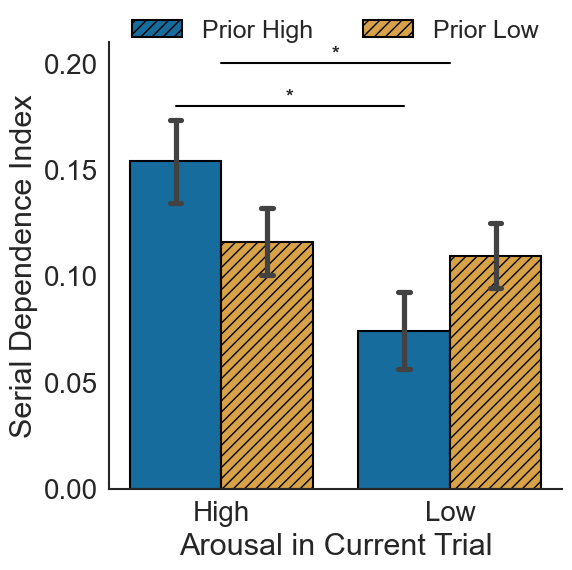


Figure 2B saved: SD_bar.png


In [423]:
# Create Figure 2B: Serial Dependence Index
PlotData_SDI = reg_seq.copy()

# Map condition names for plotting
PlotData_SDI['Current_Label'] = PlotData_SDI['Condition_Current'].map({'H': 'High', 'L': 'Low'})
PlotData_SDI['Prior_Label'] = PlotData_SDI['Condition_Prior'].map({'H': 'Prior High', 'L': 'Prior Low'})

plt.figure(figsize=(6, 6))

# Create barplot
ax = sns.barplot(
    data=PlotData_SDI,
    x='Current_Label',
    y='Slope',
    hue='Prior_Label',
    order=['High', 'Low'],
    hue_order=['Prior High', 'Prior Low'],
    palette=colors_2level,
    errorbar=('se', 1),
    capsize=0.1,
    edgecolor='black',
    linewidth=1.5
)

# Add hatching patterns 
for i, bar in enumerate(ax.patches):
    if i > 1: 
        bar.set_hatch('///')


y_max = 0.18

# Interaction effect within High arousal (left pair)
add_significance_stars(ax, -0.2, 0.8, y_max ,  height_offset=0, p_value=0.03)

# Main effect of current arousal (High vs Low)
add_significance_stars(ax, 0, 1, y_max + 0.02, height_offset=0, p_value=0.04)

# Formatting
ax.set_xlabel('Arousal in Current Trial', fontsize=22)
ax.set_ylabel('Serial Dependence Index', fontsize=22)
ax.tick_params(labelsize=20, top=False, bottom=False, left=False, right=False)
ax.legend(title='', fontsize=18, frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
sns.despine(top=True, right=True, left=False, bottom=False)

plt.tight_layout()
plt.savefig(os.path.join(FigurePath, 'SD_bar.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure 2B saved: SD_bar.png")


In [424]:
# Statistical test: RM-ANOVA for General Bias (SD context)
anova_gb_sd = pg.rm_anova(
    data=reg_seq,
    dv='Intercept',
    within=['Condition_Prior', 'Condition_Current'],
    subject='SubID',
    effsize='np2'
)

print("\n=== RM-ANOVA: General Bias (SD Context) ===")
pg.print_table(anova_gb_sd, floatfmt='.3f')


=== RM-ANOVA: General Bias (SD Context) ===

ANOVA SUMMARY

Source                                  SS    ddof1    ddof2     MS       F    p-unc    p-GG-corr    np2    eps
-----------------------------------  -----  -------  -------  -----  ------  -------  -----------  -----  -----
Condition_Prior                      0.000        1       20  0.000   0.048    0.829        0.829  0.002  1.000
Condition_Current                    0.006        1       20  0.006  10.828    0.004        0.004  0.351  1.000
Condition_Prior * Condition_Current  0.000        1       20  0.000   0.163    0.691        0.691  0.008  1.000



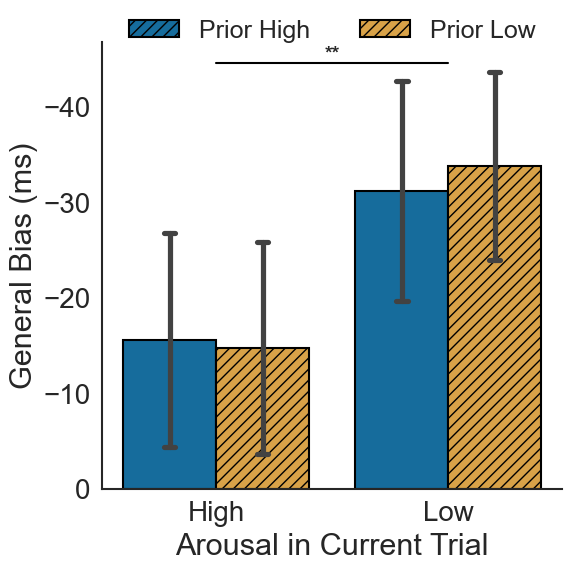


Figure 2C saved: GB_bar.png


In [425]:
# Create Figure 2C: General Bias (SD Context)
PlotData_GB_SD = reg_seq.copy()
PlotData_GB_SD['Intercept_ms'] = PlotData_GB_SD['Intercept'] * 1000  # Convert to ms
PlotData_GB_SD['Current_Label'] = PlotData_GB_SD['Condition_Current'].map({'H': 'High', 'L': 'Low'})
PlotData_GB_SD['Prior_Label'] = PlotData_GB_SD['Condition_Prior'].map({'H': 'Prior High', 'L': 'Prior Low'})

plt.figure(figsize=(6, 6))

# Create barplot
ax = sns.barplot(
    data=PlotData_GB_SD,
    x='Current_Label',
    y='Intercept_ms',
    hue='Prior_Label',
    order=['High', 'Low'],
    hue_order=['Prior High', 'Prior Low'],
    palette=colors_2level,
    errorbar=('se', 1),
    capsize=0.1,
    edgecolor='black',
    linewidth=1.5
)

# Add hatching patterns - only on second bars (Prior Low)
for i, bar in enumerate(ax.patches):
    if i > 1:  # Only second bar of each pair
        bar.set_hatch('///')

# Get the max value before inversion
y_vals = PlotData_GB_SD.groupby('Current_Label')['Intercept_ms'].mean()
y_max = y_vals.max()
y_min = y_vals.min()

# Invert y-axis so negative values appear UP
ax.invert_yaxis()

# Add significance markers based on manuscript image
# Position for inverted axis - use negative offset
add_significance_stars(ax, 0, 1, y_min - abs(y_max - y_min) * 0.7, p_value=0.005)

# Formatting
ax.set_xlabel('Arousal in Current Trial', fontsize=22)
ax.set_ylabel('General Bias (ms)', fontsize=22)
ax.tick_params(labelsize=20, top=False, bottom=False, left=False, right=False)
ax.legend(title='', fontsize=18, frameon=False, loc='upper center', bbox_to_anchor=(0.5, 1.1), ncol=2)
sns.despine(top=True, right=True, left=False, bottom=False)

plt.tight_layout()
plt.savefig(os.path.join(FigurePath, 'GB_bar.png'), dpi=300, bbox_inches='tight')
plt.show()

print("\nFigure 2C saved: GB_bar.png")


### Figure 2D & 2E: n-back Analysis

Analyzes serial dependence across multiple trial lags (n-2 to n+2) separately for high and low arousal in the current trial.

In [426]:
# Load n-back analysis data
# This data includes trials coded for their temporal relationship (n-back position)
nback_files = [
    'AllSubCleanBackData1.csv',
    'AllSubCleanBackData2.csv',
    'AllSubCleanBackData3.csv',
    'AllSubCleanBackData-1.csv',
    'AllSubCleanBackData-2.csv'
]

# Load and combine all n-back datasets
nback_dfs = []
for file in nback_files:
    filepath = os.path.join(DataPath, file)
    if os.path.exists(filepath):
        df = pd.read_csv(filepath)
        if 'Unnamed: 0' in df.columns:
            df = df.drop(columns=['Unnamed: 0'])
        nback_dfs.append(df)
    else:
        print(f"Warning: {file} not found")

if nback_dfs:
    raw_nback = pd.concat(nback_dfs, ignore_index=True)
    
    # Filter data
    raw_nback = raw_nback.query('TimeOutlier != 1 & RT_Outlier != 1 & TimeUnRes != 1')
    raw_nback = raw_nback.query('PressTimeError != 9999')
    
    # Remove invalid n-back values (4, 9, 10 are control codes)
    raw_nback = raw_nback[~raw_nback['nBack'].isin([4, 9, 10])]
    
    # Drop rows with NaN in critical columns
    raw_nback = raw_nback.dropna(subset=['nBack', 'nBack_Time', 'nBack_TrialType'])
    
    print(f"\nN-back data loaded: {len(raw_nback)} trials")
    print(f"N-back values: {sorted(raw_nback['nBack'].unique())}")
else:
    print("\nError: No n-back data files found!")
    raw_nback = pd.DataFrame()  # Empty dataframe



N-back data loaded: 65980 trials
N-back values: [-2, -1, 1, 2, 3]


In [427]:
# Regression analysis for each n-back level
# NOTE: Unlike main SD analysis, nBack_Time is NOT centered here
# We regress separately for each lag, so centering not needed
if not raw_nback.empty:
    reg_nback_results = []
    
    for (sub, trial, nback, nback_trial), group in raw_nback.groupby(
        ['SubID', 'TrialType', 'nBack', 'nBack_TrialType']
    ):
        # Skip if insufficient data
        if len(group) < 3:
            continue
        
        # Check if nBack_Time has variance (needed for regression)
        if group['nBack_Time'].nunique() < 2:
            continue  # Skip if all nBack_Time values are identical
            
        # Perform linear regression: PressTimeError ~ nBack_Time (NOT centered)
        slope, intercept, r_value, p_value, std_err = linregress(
            group['nBack_Time'], group['PressTimeError']
        )
        
        reg_nback_results.append({
            'SubID': sub,
            'TrialType': trial,  # Current trial arousal
            'nBack': nback,
            'nBack_TrialType': nback_trial,  # Prior trial arousal
            'Slope': slope,
            'Intercept': intercept,
            'r_value': r_value,
            'p_value': p_value
        })
    
    reg_seq_con = pd.DataFrame(reg_nback_results)
    
    print(f"\nN-back regression models fitted: {len(reg_seq_con)}")
    print("\nSample data:")
    print(reg_seq_con.head(10))
else:
    reg_seq_con = pd.DataFrame()



N-back regression models fitted: 420

Sample data:
   SubID TrialType  nBack nBack_TrialType     Slope  Intercept   r_value  \
0    1.0      High     -2            High  0.093844  -0.194315  0.096638   
1    1.0      High     -2             Low -0.045239   0.023271 -0.048816   
2    1.0      High     -1            High -0.050445   0.026965 -0.054322   
3    1.0      High     -1             Low -0.033254  -0.011308 -0.033413   
4    1.0      High      1            High  0.034068  -0.073501  0.034709   
5    1.0      High      1             Low  0.111793  -0.167490  0.118292   
6    1.0      High      2            High  0.180273  -0.277725  0.187160   
7    1.0      High      2             Low  0.105365  -0.139229  0.108267   
8    1.0      High      3            High  0.161472  -0.230419  0.161333   
9    1.0      High      3             Low  0.013015  -0.047570  0.013908   

    p_value  
0  0.336371  
1  0.497961  
2  0.503417  
3  0.681787  
4  0.671187  
5  0.140069  
6  0.058351  


=== Statistical Tests: High Arousal N-back ===
n+2: Prior High p=0.443, Prior Low p=0.232
n+1: Prior High p=0.010, Prior Low p=0.247
n-1: Prior High p=0.000, Prior Low p=0.000
n-2: Prior High p=0.001, Prior Low p=0.014
n-3: Prior High p=0.314, Prior Low p=0.060


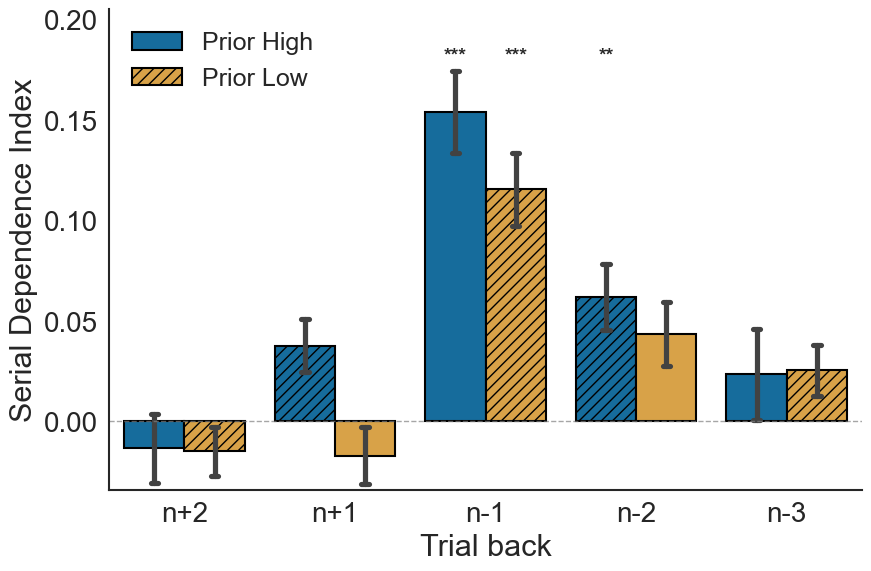


Figure 2D saved: nBack_currentHigh.png


In [428]:
# Create Figure 2D: N-back for High Arousal in Current Trial
if not reg_seq_con.empty:
    # Filter for current High arousal
    PlotData_nback_High = reg_seq_con[reg_seq_con['TrialType'] == 'High'].copy()
    
    # Map prior arousal labels
    PlotData_nback_High['Prior_Label'] = PlotData_nback_High['nBack_TrialType'].map(
        {'High': 'Prior High', 'Low': 'Prior Low'}
    )
    
    # Define CORRECT n-back order (matches original code)
    # nBack values: -2, -1, 1, 2, 3 (sorted naturally by seaborn)
    # Labels:      n+2, n+1, n-1, n-2, n-3
    nback_order = [-2, -1, 1, 2, 3]  # Future trials first, then past trials
    nback_labels = ['n+2', 'n+1', 'n-1', 'n-2', 'n-3']
    
    plt.figure(figsize=(9, 6))
    
    # Create barplot
    ax = sns.barplot(
        data=PlotData_nback_High,
        x='nBack',
        y='Slope',
        hue='Prior_Label',
        order=nback_order,
        hue_order=['Prior High', 'Prior Low'],
        palette=colors_2level,
        errorbar=('se', 1),
        capsize=0.1,
        edgecolor='black',
        linewidth=1.5
    )
    
    # Add hatching patterns - only on second bars (Prior Low)
    for i, bar in enumerate(ax.patches):
        if i % 2 == 1:  # Only second bar of each pair (Prior Low)
            bar.set_hatch('///')
    
    # Set y-axis limits to avoid excessive white space
    y_min = PlotData_nback_High.groupby(['nBack', 'Prior_Label'])['Slope'].mean().min()
    y_max = PlotData_nback_High.groupby(['nBack', 'Prior_Label'])['Slope'].mean().max()
    y_range = y_max - y_min
    ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.3 * y_range)
    
    # Add reference line at y=0
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    
    # Perform statistical tests for each n-back level
    print("\n=== Statistical Tests: High Arousal N-back ===")
    sig_positions = []
    for nb_idx, nb in enumerate(nback_order):
        data_nb = PlotData_nback_High[PlotData_nback_High['nBack'] == nb]
        
        # Test Prior High vs zero
        prior_high = data_nb[data_nb['nBack_TrialType'] == 'High']['Slope']
        if len(prior_high) > 0:
            t_high = pg.ttest(prior_high, 0)
            p_high = t_high['p-val'].values[0]
        else:
            p_high = 1.0
        
        # Test Prior Low vs zero
        prior_low = data_nb[data_nb['nBack_TrialType'] == 'Low']['Slope']
        if len(prior_low) > 0:
            t_low = pg.ttest(prior_low, 0)
            p_low = t_low['p-val'].values[0]
        else:
            p_low = 1.0
        
        print(f"{nback_labels[nb_idx]}: Prior High p={p_high:.3f}, Prior Low p={p_low:.3f}")
        
        # Store significant results for plotting
        if p_high < 0.001:
            sig_positions.append((nb_idx - 0.2, '***'))
        elif p_high < 0.01:
            sig_positions.append((nb_idx - 0.2, '**'))
            
        if p_low < 0.001:
            sig_positions.append((nb_idx + 0.2, '***'))
        elif p_low < 0.01:
            sig_positions.append((nb_idx + 0.2, '**'))
    
    # Add significance markers
    y_sig = y_max + 0.15 * y_range
    for x_pos, stars in sig_positions:
        ax.text(x_pos, y_sig, stars, ha='center', fontsize=14, weight='bold')
    
    # Set x-axis labels to match original
    ax.set_xticklabels(nback_labels, fontsize=19)
    
    # Formatting
    ax.set_xlabel('Trial back', fontsize=22)
    ax.set_ylabel('Serial Dependence Index', fontsize=22)
    ax.tick_params(labelsize=20, top=False, bottom=False, left=False, right=False)
    ax.legend(title='', fontsize=18, frameon=False, loc='upper left')
    sns.despine(top=True, right=True, left=False, bottom=False)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FigurePath, 'nBack_currentHigh.png'), dpi=600, bbox_inches='tight')
    plt.show()
    
    print("\nFigure 2D saved: nBack_currentHigh.png")
else:
    print("\nSkipping Figure 2D: No n-back data available")



=== Statistical Tests: Low Arousal N-back ===
n+2: Prior High p=0.923, Prior Low p=0.409
n+1: Prior High p=0.298, Prior Low p=0.143
n-1: Prior High p=0.000, Prior Low p=0.000
n-2: Prior High p=0.069, Prior Low p=0.135
n-3: Prior High p=0.393, Prior Low p=0.629


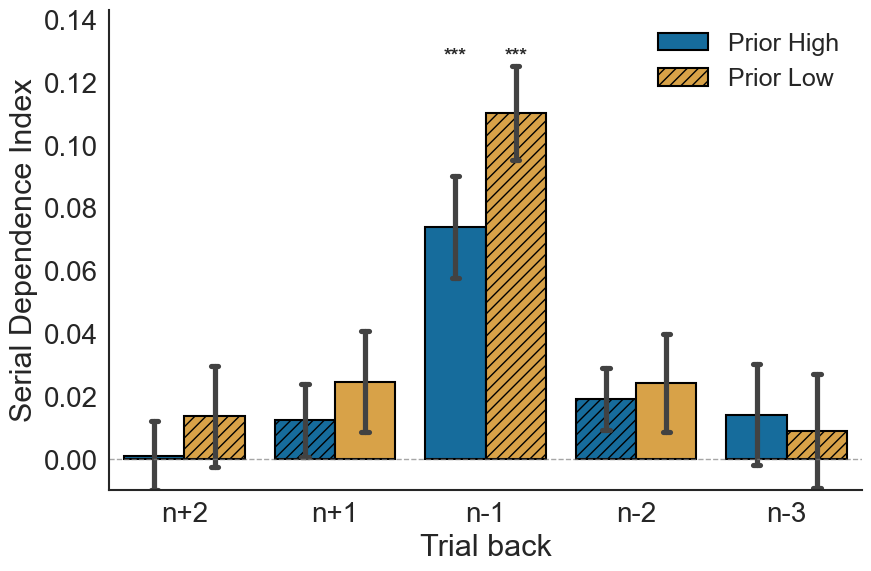


Figure 2E saved: nBack_currentLow.png


In [429]:
# Create Figure 2E: N-back for Low Arousal in Current Trial
if not reg_seq_con.empty:
    # Filter for current Low arousal
    PlotData_nback_Low = reg_seq_con[reg_seq_con['TrialType'] == 'Low'].copy()
    
    # Map prior arousal labels
    PlotData_nback_Low['Prior_Label'] = PlotData_nback_Low['nBack_TrialType'].map(
        {'High': 'Prior High', 'Low': 'Prior Low'}
    )
    
    # Use same nback_order and nback_labels as Figure 2D
    nback_order = [-2, -1, 1, 2, 3]
    nback_labels = ['n+2', 'n+1', 'n-1', 'n-2', 'n-3']
    
    plt.figure(figsize=(9, 6))
    
    # Create barplot
    ax = sns.barplot(
        data=PlotData_nback_Low,
        x='nBack',
        y='Slope',
        hue='Prior_Label',
        order=nback_order,
        hue_order=['Prior High', 'Prior Low'],
        palette=colors_2level,
        errorbar=('se', 1),
        capsize=0.1,
        edgecolor='black',
        linewidth=1.5
    )
    
    # Add hatching patterns - only on second bars (Prior Low)
    for i, bar in enumerate(ax.patches):
        if i % 2 == 1:
            bar.set_hatch('///')
    
    # Set y-axis limits
    y_min = PlotData_nback_Low.groupby(['nBack', 'Prior_Label'])['Slope'].mean().min()
    y_max = PlotData_nback_Low.groupby(['nBack', 'Prior_Label'])['Slope'].mean().max()
    y_range = y_max - y_min
    ax.set_ylim(y_min - 0.1 * y_range, y_max + 0.3 * y_range)
    
    # Add reference line at y=0
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1, alpha=0.7)
    
    # Perform statistical tests
    print("\n=== Statistical Tests: Low Arousal N-back ===")
    sig_positions = []
    for nb_idx, nb in enumerate(nback_order):
        data_nb = PlotData_nback_Low[PlotData_nback_Low['nBack'] == nb]
        
        prior_high = data_nb[data_nb['nBack_TrialType'] == 'High']['Slope']
        if len(prior_high) > 0:
            t_high = pg.ttest(prior_high, 0)
            p_high = t_high['p-val'].values[0]
        else:
            p_high = 1.0
        
        prior_low = data_nb[data_nb['nBack_TrialType'] == 'Low']['Slope']
        if len(prior_low) > 0:
            t_low = pg.ttest(prior_low, 0)
            p_low = t_low['p-val'].values[0]
        else:
            p_low = 1.0
        
        print(f"{nback_labels[nb_idx]}: Prior High p={p_high:.3f}, Prior Low p={p_low:.3f}")
        
        # Store significant results
        if p_high < 0.001:
            sig_positions.append((nb_idx - 0.2, '***'))
        elif p_high < 0.01:
            sig_positions.append((nb_idx - 0.2, '**'))
            
        if p_low < 0.001:
            sig_positions.append((nb_idx + 0.2, '***'))
        elif p_low < 0.01:
            sig_positions.append((nb_idx + 0.2, '**'))
    
    # Add significance markers
    y_sig = y_max + 0.15 * y_range
    for x_pos, stars in sig_positions:
        ax.text(x_pos, y_sig, stars, ha='center', fontsize=14, weight='bold')
    
    # Set x-axis labels
    ax.set_xticklabels(nback_labels, fontsize=19)
    
    # Formatting
    ax.set_xlabel('Trial back', fontsize=22)
    ax.set_ylabel('Serial Dependence Index', fontsize=22)
    ax.tick_params(labelsize=20, top=False, bottom=False, left=False, right=False)
    ax.legend(title='', fontsize=18, frameon=False, loc='upper right')
    sns.despine(top=True, right=True, left=False, bottom=False)
    
    plt.tight_layout()
    plt.savefig(os.path.join(FigurePath, 'nBack_currentLow.png'), dpi=600, bbox_inches='tight')
    plt.show()
    
    print("\nFigure 2E saved: nBack_currentLow.png")
else:
    print("\nSkipping Figure 2E: No n-back data available")


## Summary

This notebook has successfully reproduced:

**Figure 1: Central Tendency Effects**
- A. Paradigm schematic (external file)
- B. Time error curves by arousal and valence
- C. Central tendency index (no significant effect of arousal or valence)
- D. General bias (significant effect of arousal: p < 0.01)

**Figure 2: Serial Dependence Effects**
- A. Serial dependence curves for all four conditions (HH, HL, LH, LL)
- B. Serial dependence index (significant interaction: prior × current arousal)
- C. General bias (significant main effect of current arousal: p < 0.01)
- D. N-back analysis for high arousal (significant SD at n-1: p < 0.001)
- E. N-back analysis for low arousal (significant SD at n-1 for prior low: p < 0.001)

All figures use grayscale-compatible colors suitable for non-color printing.

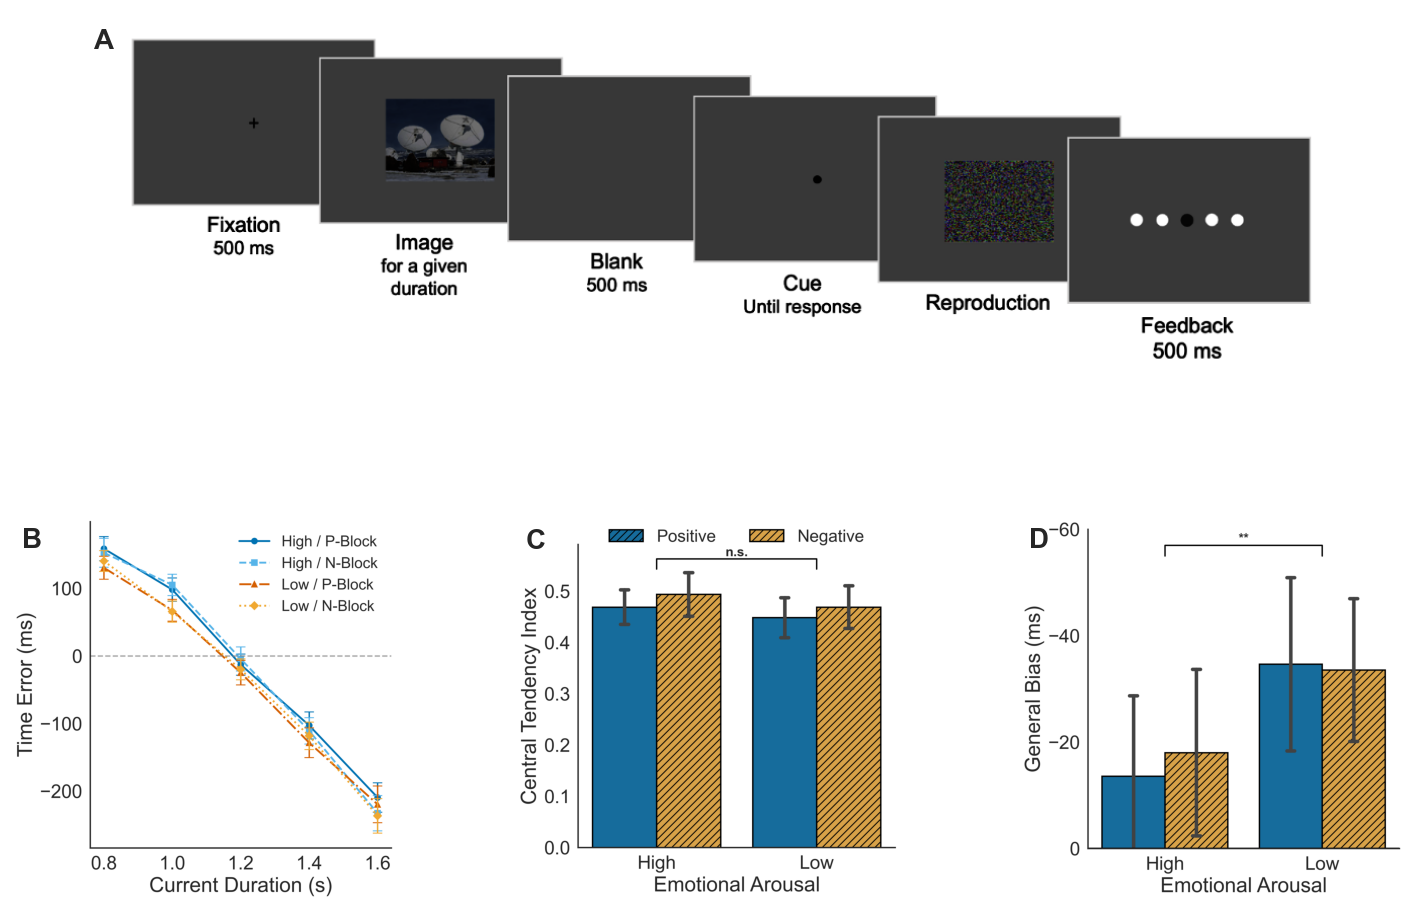

In [430]:
# Combine Figure 1: Central Tendency Effects
# Layout: A on top row (full width), B,C,D on bottom row

from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# Load individual figures
paradigm = Image.open(os.path.join('manuscript/figures', 'paradigm.png'))
fig1b = Image.open(os.path.join(FigurePath, 'Valence_CT_Error_bar.png'))
fig1c = Image.open(os.path.join(FigurePath, 'Res_CT_bar.png'))
fig1d = Image.open(os.path.join(FigurePath, 'GB_CT_bar.png'))

# Create figure with custom layout
fig = plt.figure(figsize=(18, 12))
gs = gridspec.GridSpec(2, 3, figure=fig, hspace=0.25, wspace=0.3,
                       height_ratios=[1, 1.2])  # Top row slightly shorter

# A: Paradigm - full top row
ax_a = fig.add_subplot(gs[0, :])  # Spans all 3 columns
ax_a.imshow(paradigm)
ax_a.axis('off')
# Add label at top-left, smaller and positioned to avoid overlap
ax_a.text(0.01, 0.95, 'A', transform=ax_a.transAxes,
          fontsize=20, fontweight='bold', va='top', ha='left')

# Bottom row: B, C, D
bottom_images = [fig1b, fig1c, fig1d]
bottom_labels = ['B', 'C', 'D']

for i, (img, label) in enumerate(zip(bottom_images, bottom_labels)):
    ax = fig.add_subplot(gs[1, i])
    ax.imshow(img)
    ax.axis('off')
    
    # Add subfigure label - smaller size, positioned to avoid y-axis
    ax.text(0.03, 0.97, label, transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.savefig(os.path.join('manuscript/figures', 'image1.png'), dpi=300, bbox_inches='tight')
plt.show()




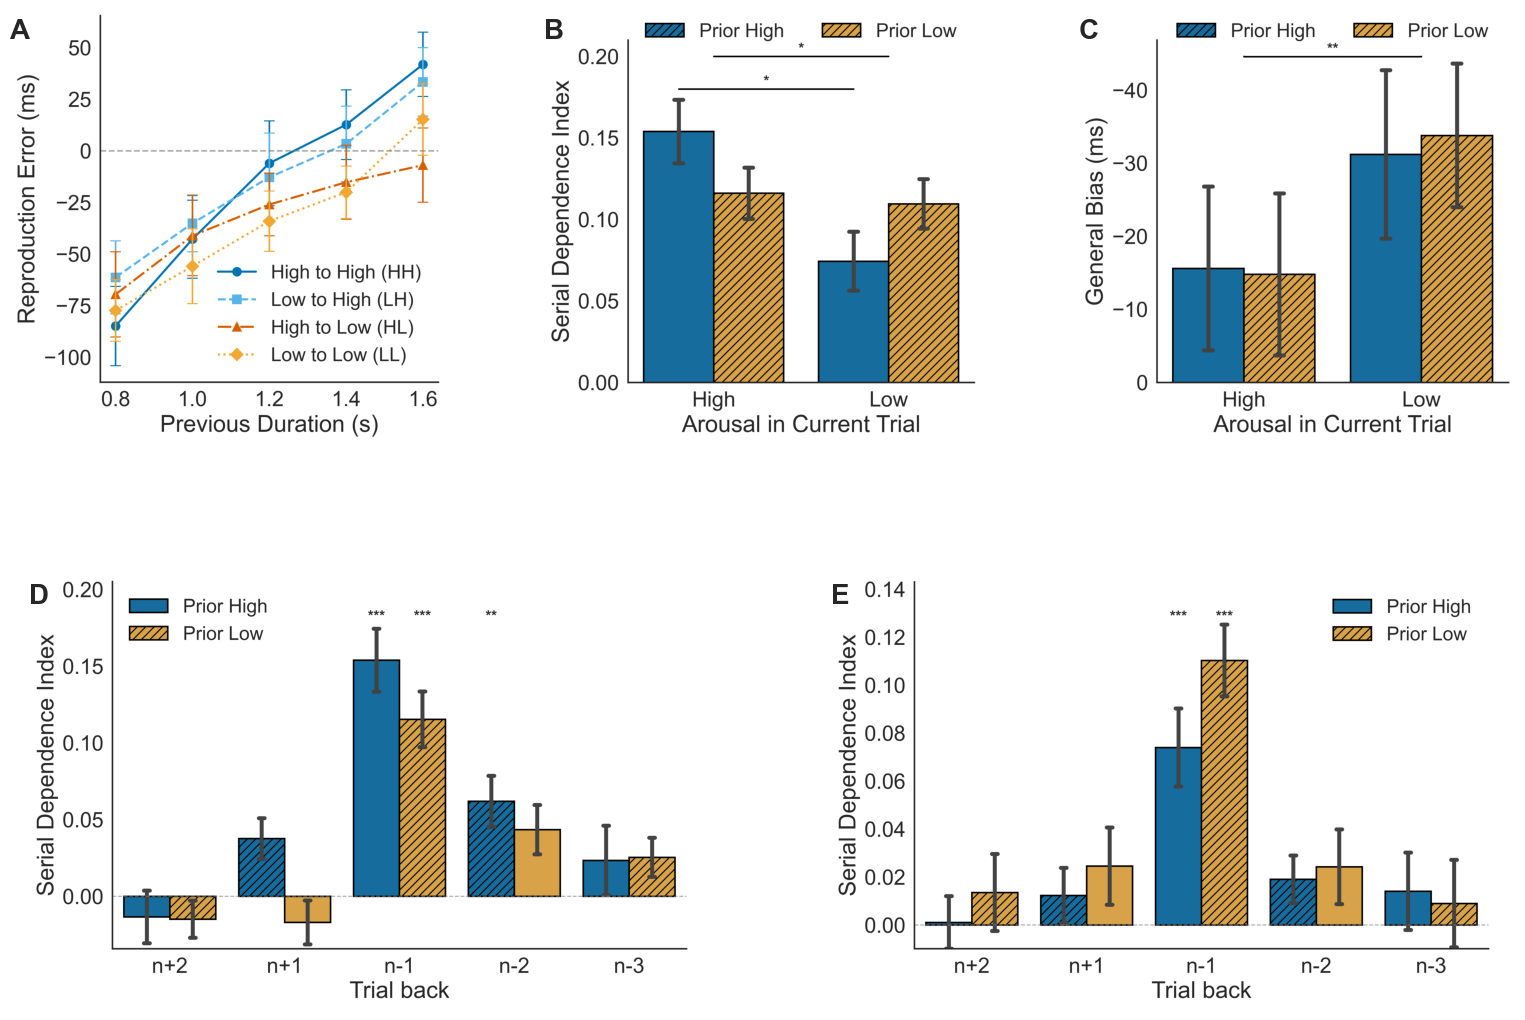

In [431]:
# Combine Figure 2: Serial Dependence Effects
# Layout: Top row (A, B, C), Bottom row (D, E with gap)

# Load individual figures
fig2a = Image.open(os.path.join(FigurePath, 'SD_point.png'))
fig2b = Image.open(os.path.join(FigurePath, 'SD_bar.png'))
fig2c = Image.open(os.path.join(FigurePath, 'GB_bar.png'))
fig2d = Image.open(os.path.join(FigurePath, 'nBack_currentHigh.png'))
fig2e = Image.open(os.path.join(FigurePath, 'nBack_currentLow.png'))

# Create figure with custom layout
fig = plt.figure(figsize=(20, 13))

# Use GridSpec with 5 columns to create gap between D and E
gs = gridspec.GridSpec(2, 6, figure=fig, hspace=0.3, wspace=0.25,
                       height_ratios=[1, 1],
                       width_ratios=[1, 1, 1, 1, 1, 1])  # Equal column widths

# Top row: A, B, C (each spans ~1.67 columns for balance)
ax_a = fig.add_subplot(gs[0, 0:2])  # A spans first 2 columns
ax_a.imshow(fig2a)
ax_a.axis('off')
ax_a.text(0.0, 0.98, 'A', transform=ax_a.transAxes,
          fontsize=20, fontweight='bold', va='top', ha='left')

ax_b = fig.add_subplot(gs[0, 2:4])  # B in middle
ax_b.imshow(fig2b)
ax_b.axis('off')
ax_b.text(0.0, 0.98, 'B', transform=ax_b.transAxes,
          fontsize=20, fontweight='bold', va='top', ha='left')


ax_c = fig.add_subplot(gs[0, 4:6])  # C spans last 2 columns
ax_c.imshow(fig2c)
ax_c.axis('off')
ax_c.text(0.0, 0.98, 'C', transform=ax_c.transAxes,
          fontsize=20, fontweight='bold', va='top', ha='left')

# Bottom row: D and E with gap in middle
ax_d = fig.add_subplot(gs[1, 0:3])  # D spans first 2 columns
ax_d.imshow(fig2d)
ax_d.axis('off')
ax_d.text(0.0, 0.98, 'D', transform=ax_d.transAxes,
          fontsize=20, fontweight='bold', va='top', ha='left')

# Column 2 is gap

ax_e = fig.add_subplot(gs[1, 3:6])  # E spans last 2 columns
ax_e.imshow(fig2e)
ax_e.axis('off')
ax_e.text(0.0, 0.98, 'E', transform=ax_e.transAxes,
          fontsize=20, fontweight='bold', va='top', ha='left')

plt.tight_layout()
plt.savefig(os.path.join('manuscript/figures', 'image2.png'), dpi=300, bbox_inches='tight')
plt.show()
